In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Imports used for the deeplearning model:
    NumPy – Used for numerical operations, handling arrays, converting data types, and processing
    feature/target values before feeding them into the neural network.
    Pandas – Used for loading the dataset, cleaning missing values, transforming columns, and preparing
    the DataFrame for preprocessing.
    TensorFlow / Keras – Provides the tools to build the deep learning model
    Keras Layers – Used to build the architecture of the neural network 
    load_model – Allows reloading a previously saved model for evaluation or further testing.
    train_test_split – Splits the dataset into training and testing sets for model evaluation.
    StandardScaler – Scales numerical features so that all inputs have similar ranges, improving neural
    network performance and convergence.
    LabelEncoder – Converts categorical labels into numeric form for use in the model.
    EarlyStopping – Stops training when validation loss stops improving, helping prevent overfitting.

In [23]:
df = pd.read_csv("Automobile_data.csv", na_values='?')

print(f"Original dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

df = df[df['price'].notna()]


Original dataset shape: (205, 26)
Columns: ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']


In [25]:
df.shape
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [27]:
y = df['price'].astype(np.float32).values
X = df.drop('price', axis=1)

In [29]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64', 'float32']).columns.tolist()


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)


In [31]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)


In [33]:


print("Processed training shape:", X_train.shape)
print("Processed testing shape:", X_test.shape)

Processed training shape: (160, 74)
Processed testing shape: (41, 74)


In [35]:
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])


2025-11-20 19:02:03.858836: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-20 19:02:03.858918: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-20 19:02:03.858932: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-20 19:02:03.859099: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-20 19:02:03.859140: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [37]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae'],
    run_eagerly=False
)

print("\n" + "="*50)
model.summary()
print("="*50)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,481 (80.00 KB)

 Trainable params: 20,481 (80.00 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
print("Model is being trained...")

Model is being trained...


In [41]:
es = EarlyStopping(
    patience=10,
    monitor='val_loss, val_mae',
    mode='max',
    restore_best_weights=True
)

In [43]:

model.save('automobile_price_model.keras')
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es],
    verbose=1
)

Epoch 1/200


2025-11-20 19:02:09.662430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-11-20 19:02:09.667228: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 198475248.0000 - mae: 12553.9023 - val_loss: 224751680.0000 - val_mae: 12654.0859
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 198472800.0000 - mae: 12553.7969 - val_loss: 224749856.0000 - val_mae: 12654.0195
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 198471120.0000 - mae: 12553.7402 - val_loss: 224748736.0000 - val_mae: 12653.9805
Epoch 4/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 186543040.0000 - mae: 12167.3047

/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss, val_mae` which is not available. Available metrics are: loss,mae,val_loss,val_mae
  current = self.get_monitor_value(logs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 198468912.0000 - mae: 12553.6650 - val_loss: 224747920.0000 - val_mae: 12653.9521
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 198467328.0000 - mae: 12553.6016 - val_loss: 224747312.0000 - val_mae: 12653.9297
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 198466576.0000 - mae: 12553.5791 - val_loss: 224746720.0000 - val_mae: 12653.9082
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 198466192.0000 - mae: 12553.5537 - val_loss: 224746080.0000 - val_mae: 12653.8848
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 198464880.0000 - mae: 12553.5117 - val_loss: 224745392.0000 - val_mae: 12653.8594
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 198463808.0000 - mae: 12553.4756 - val_loss: 224744544.0000 - val_mae: 12653.8301
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 198462672.0000 - mae: 12553.4307 - val_loss: 224743456.0000 - val_mae: 12653.7910
Epoch 11/200
4/4 ━━━━━━━━━━━━━━

In [84]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Test MAE:", mae)
print("Test RMSE:", rmse)
print("Test R² Score:", r2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test MAE: 15678.965
Test RMSE: 19187.389
Test R² Score: -2.00911808013916


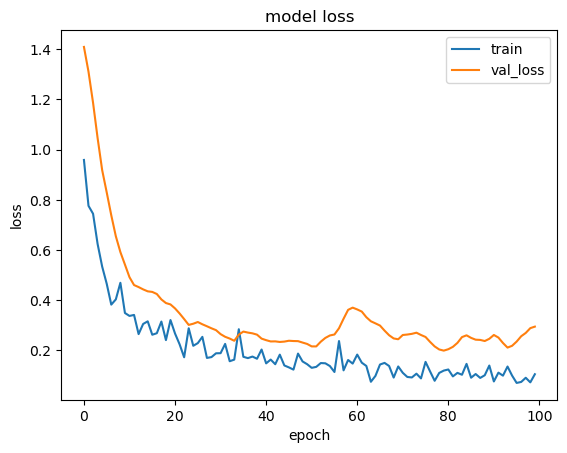

In [86]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val_loss'])
plt.show()

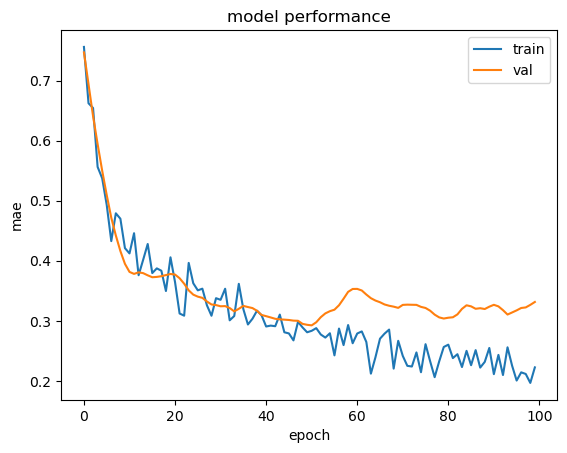

In [88]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model performance')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.show()

In [110]:
model.evaluate(X_train,y_train)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 203716352.0000 - mae: 12573.7598 


[203716352.0, 12573.759765625]

In [112]:
model.evaluate(X_test,y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 368155840.0000 - mae: 15678.9639


[368155840.0, 15678.9638671875]

In [114]:
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [122]:
index = 1
actual = y_test[index]
pred = y_pred[index]

print("Actual price:", actual)
print("Predicted price:", pred)

Actual price: 41315.0
Predicted price: 1.3691927


In [45]:
y_pred = model.predict(X_test).flatten()

# -------------------------------------
# 9. EVALUATION
# -------------------------------------

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nModel Performance:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)



# Print every result
for i in range(len(y_test)):
    print(f"Car {i+1}:  Actual = {y_test[i]:,.2f}   |   Predicted = {y_pred[i]:,.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Model Performance:
MAE: 3511.593
RMSE: 5256.8774
R²: 0.7741276025772095
Car 1:  Actual = 8,249.00   |   Predicted = 6,297.48
Car 2:  Actual = 41,315.00   |   Predicted = 25,436.08
Car 3:  Actual = 6,855.00   |   Predicted = 6,674.00
Car 4:  Actual = 9,258.00   |   Predicted = 6,873.05
Car 5:  Actual = 11,850.00   |   Predicted = 14,973.23
Car 6:  Actual = 5,572.00   |   Predicted = 5,476.51
Car 7:  Actual = 35,056.00   |   Predicted = 25,908.33
Car 8:  Actual = 9,988.00   |   Predicted = 9,614.19
Car 9:  Actual = 15,998.00   |   Predicted = 20,285.82
Car 10:  Actual = 35,550.00   |   Predicted = 28,866.77
Car 11:  Actual = 28,176.00   |   Predicted = 22,602.77
Car 12:  Actual = 9,495.00   |   Predicted = 8,343.55
Car 13:  Actual = 9,989.00   |   Predicted = 13,837.24
Car 14:  Actual = 8,499.00   |   Predicted = 10,449.50
Car 15:  Actual = 13,295.00   |   Predicted = 14,973.02
Car 16:  Actual = 7,775.00   |   Predicted = 8,203.87
Car 17:  Actual = 